In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [3]:
df = pd.read_csv("household_power_consumption.txt", delimiter=";",na_values="?")

In [4]:
# посмотрим, что внутри

In [5]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Date                     object
Time                     object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


In [20]:
# на моей машине кластеризация на таком датасете считается дюже долго.
# для сокращения времени исполнения буду брать только кусочек датасета

In [34]:
print("Оригинальный датасет {}".format(df.shape))
df_short = df.dropna()
print("Удалили миссинги {}".format(df_short.shape))
df_short = df_short.sample(frac=0.005, random_state = 42)
print("Берем рандомный кусочек {}".format(df_short.shape))


Оригинальный датасет (2075259, 9)
Удалили миссинги (2049280, 9)
Берем рандомный кусочек (10246, 9)


In [35]:
df_scaled = StandardScaler().fit_transform(df_short.drop(columns=["Date", "Time"]))

In [37]:
# построим KMeans и посмотрим оптимальное число кластеров с помощью метода локтя

In [38]:
from sklearn.metrics import silhouette_score
inertia = []
silouette = []
for k in tqdm(pd.np.arange(2,50)):
    km = KMeans(k, n_jobs=-1)
    km.fit(df_scaled)
    inertia.append(km.inertia_)
    labels = km.predict(df_scaled)
    silouette.append(silhouette_score(df_scaled, labels))

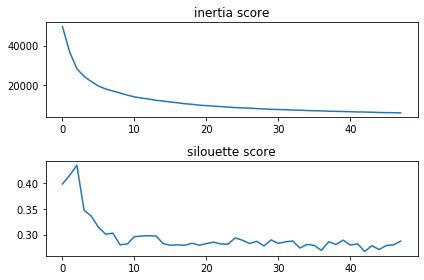

In [39]:
fig, ax = plt.subplots(2)
# fig.set_size(10,10)
ax[0].plot(inertia)
ax[0].set_title("inertia score")
ax[1].plot(silouette)
ax[1].set_title("silouette score")
fig.tight_layout()
plt.show()


In [41]:
# по методу локтя предположу, что оптимальное число кластеров - 9

In [45]:
# воспользуемся алгоритмом dbscan

In [46]:
cl1 = DBSCAN()
cl1.fit(df_scaled)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [58]:
pd.Series(cl1.labels_).value_counts()

 0     9140
-1      989
 7       20
 4       16
 11      11
 10      11
 6        9
 13       8
 9        7
 2        6
 3        5
 1        5
 8        5
 5        4
 14       4
 12       3
 15       3
dtype: int64

In [60]:
# dbscan с настройками по умолчанию насчитал 16 кластеров

In [62]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

distance_mat = pdist(df_scaled) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'ward') # linkage — реализация агломеративного алгоритма

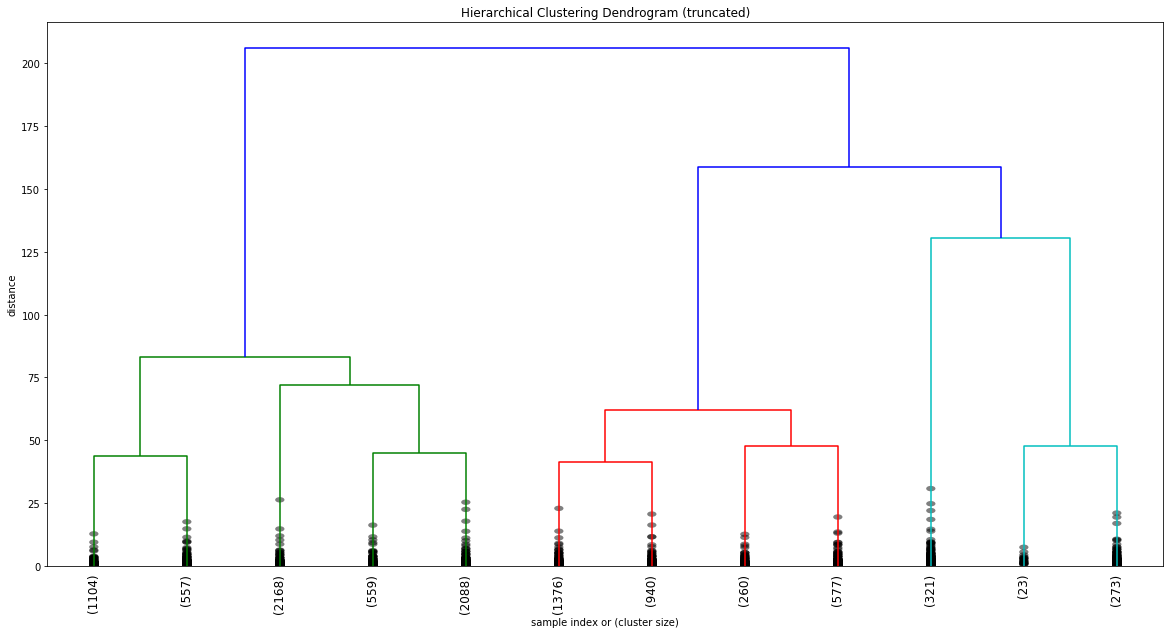

In [63]:
plt.figure(figsize=(20, 10))
# выводим размеры кластеров

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

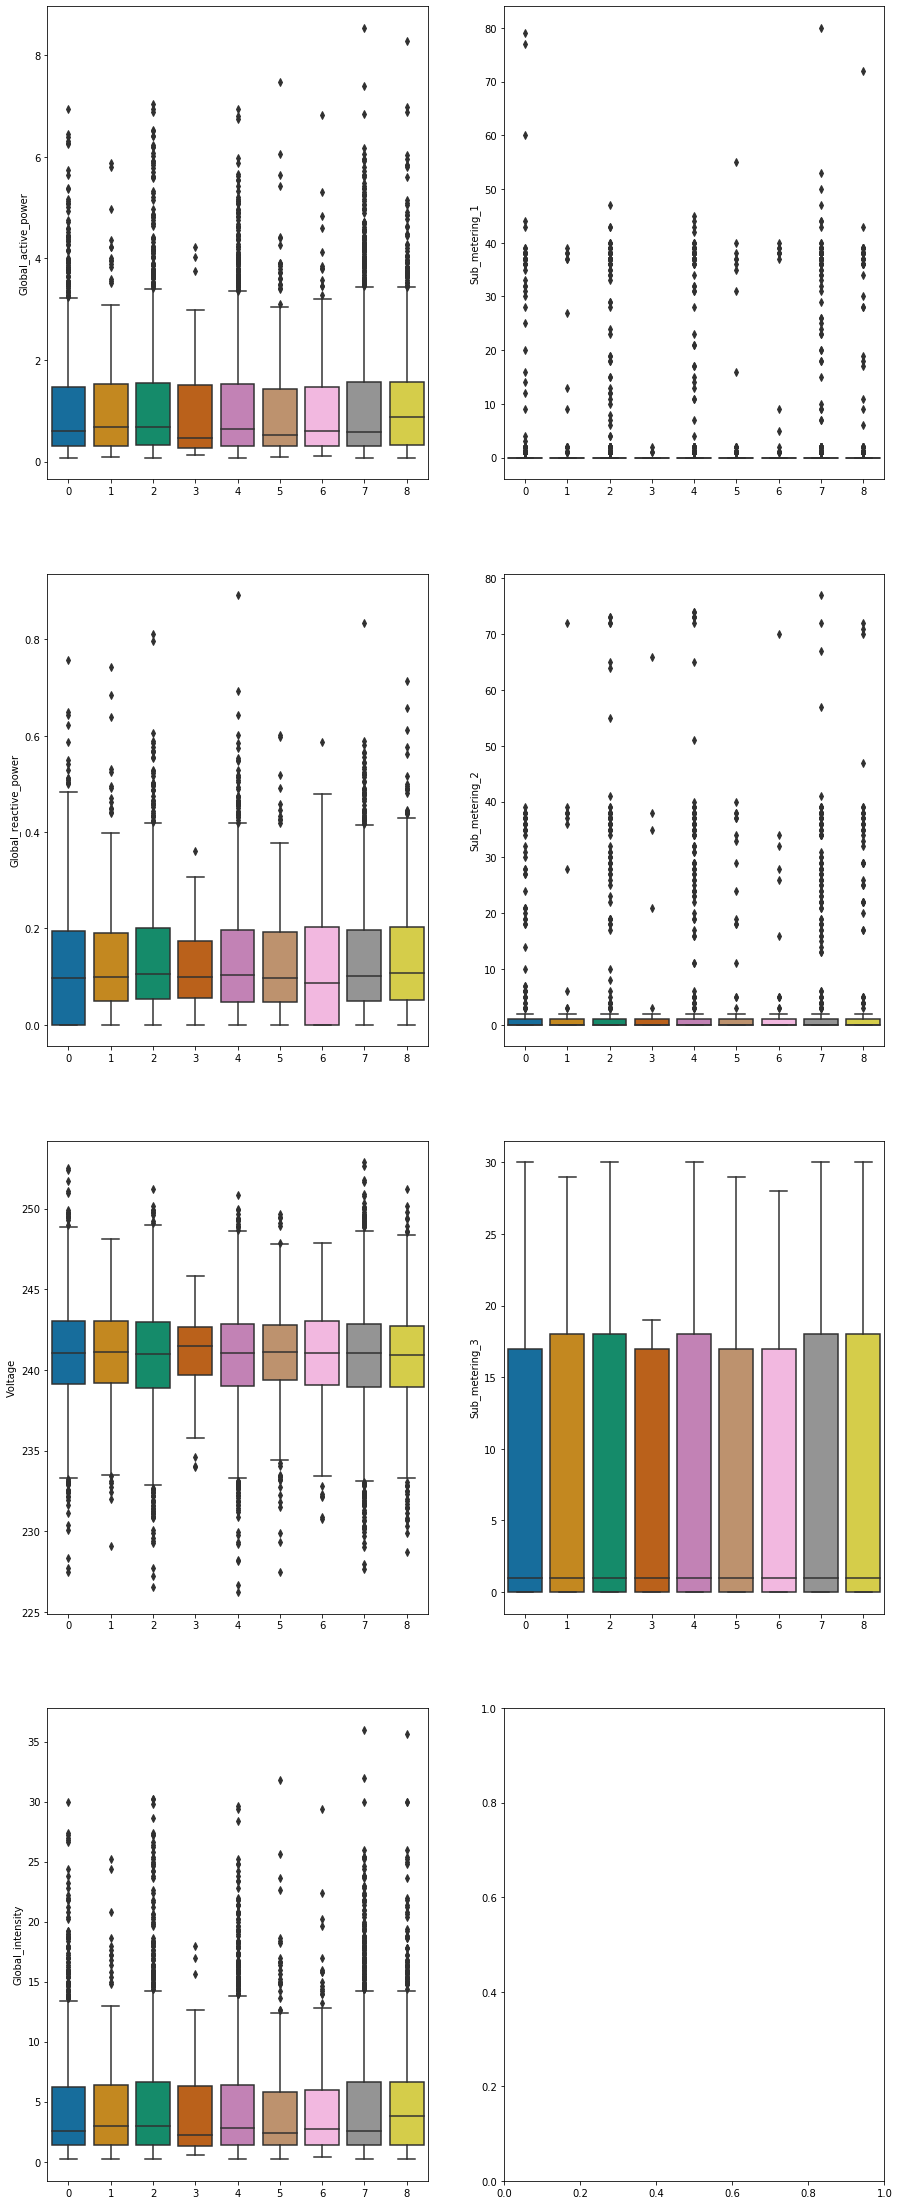

In [72]:
km = KMeans(n_clusters=9)
km.fit(df_scaled)
raw_df = df.drop(columns=["Date", "Time"])[df.index.isin(df_short.index)]

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 40))

i_col = 0
i_row = 0

for column in df.drop(columns=["Date", "Time"]).columns:
    sns.boxplot(y=column, x=km.labels_, 
                     data=raw_df, 
                     palette="colorblind", ax=ax[i_row, i_col])
    if i_row < 3:
        i_row += 1
    else:
        i_col += 1
        i_row = 0